In [1]:
import os
from collections import defaultdict

import numpy as np
from PIL import Image
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM

import shap
from shap.utils.image import (
    add_sample_images,
    check_valid_image,
    display_grid_plot,
    is_empty,
    load_image,
    make_dir,
    resize_image,
    save_image,
)

c:\Users\dinga\Documents\shapley_for_maps\.shapenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ask_model = "In short: What do you see?"

In [4]:
def get_caption(image_path):
  model_id = "vikhyatk/moondream2"
  revision = "2024-08-26"
  model = AutoModelForCausalLM.from_pretrained(
      model_id, trust_remote_code=True, revision=revision
  )
  tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)

  image = Image.open(image_path)
  enc_image = model.encode_image(image)
  return model.answer_question(enc_image, f"{ask_model}", tokenizer)

In [6]:
# directory of images to be explained
# DIR = "./test_images/"
DIR = "map_images/"

# creates or empties directory if it already exists
# make_dir(DIR)
# add_sample_images(DIR)

# directory for saving resized images
# DIR_RESHAPED = "./reshaped_images/"
# make_dir(DIR_RESHAPED)

# directory for saving masked images
DIR_MASKED = "masked_images/"
make_dir(DIR_MASKED)

In [7]:
# image_path = "map_images/image.png"  # or a local file path
# caption = get_caption(image_path)
# print("Generated Caption:", caption)

In [8]:
# check if 'test_images' folder exists and if it has any files
if not is_empty(DIR):
    X = []
    reshape = True
    files = [f for f in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, f))]

    for file in files:
        path_to_image = os.path.join(DIR, file)

        # check if file has of any of the following acceptable extensions: JPEG (JPG), PNG, GIF, BMP, JFIF
        if check_valid_image(file):
            print("\nLoading image:", file)
            print("Image caption:", get_caption(path_to_image))
            img = load_image(path_to_image)
            print("Image size:", img.shape)

            # # reshaping large image files
            # if reshape:
            #     image, reshaped_file = resize_image(path_to_image, DIR_RESHAPED)
            #     if reshaped_file:
            #         print("Reshaped image caption:", get_caption(reshaped_file))

            X.append(img)
        else:
            print("\nSkipping image due to invalid file extension:", file)

    print("\nNumber of images in test dataset:", len(X))

# # delete DIR_RESHAPED if empty
# if not os.listdir(DIR_RESHAPED):
#     os.rmdir(DIR_RESHAPED)


Loading image: london_25k.png


PhiForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Image caption: The image displays a detailed map of a city, featuring streets, parks, and rivers.
Image size: (624, 1137, 3)

Loading image: london_25k_nolabels.png
Image caption: The image displays a detailed map of a city, featuring a river running through the center, surrounded by numerous streets and buildings. The map is predominantly yellow and green, with some blue and brown accents, providing a clear representation of the city layout.
Image size: (624, 1137, 3)

Loading image: london_50k.png
Image caption: The image is a detailed map of London, England, showing the city's streets, landmarks, and surrounding areas.
Image size: (624, 1137, 3)

Loading image: london_50k_nolabels.png
Image caption: The image displays a detailed map of London, England, showing the city's streets, landmarks, and waterways.
Image size: (624, 1137, 3)

Loading image: vancouver_25k.png
Image caption: The image is a detailed map of a city, showing streets, buildings, and a body of water.
Image size: (624

In [9]:
# load transformer language model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-xsum-12-6").cuda()

In [10]:
# setting values for logging/tracking variables
make_dir(DIR_MASKED)
image_counter = 0
mask_counter = 0
masked_captions = defaultdict(list)
masked_files = defaultdict(list)


# define function f which takes input (masked image) and returns caption for it
def f(x):
    """ "
    Function to return caption for masked image(x).
    """
    global mask_counter

    # saving masked array of RGB values as an image in masked_images directory
    path_to_image = os.path.join(DIR_MASKED, f"{image_counter}_{mask_counter}.png")
    save_image(x, path_to_image)

    # get caption for masked image
    caption = get_caption(path_to_image)
    masked_captions[image_counter].append(caption)
    masked_files[image_counter].append(path_to_image)
    mask_counter += 1

    return caption


# function to take a list of images and parameters such as masking option, max evals etc. and return shap_values objects
def run_masker(
    X,
    mask_value="inpaint_ns",
    max_evals=500,
    batch_size=4,
    fixed_context=None,
    show_grid_plot=False,
    limit_grid=20,
):
    """Function to take a list of images and parameters such max evals etc. and return shap explanations (shap_values) for test images(X).
    Paramaters
    ----------
    X               : list of images which need to be explained
    mask_value      : various masking options for blurring/inpainting such as "inpaint_ns", "inpaint_telea" and "blur(pixel_size, pixel_size)"
    max_evals       : number of evaluations done of the underlying model to get SHAP values
    batch_size      : number of masked images to be evaluated at once
    fixed_context   : masking technqiue used to build partition tree with options of '0', '1' or 'None'
    show_grid_plot  : if set to True, shows grid plot of all masked images and their captions used to generate SHAP values (default: False)
    limit_grid      : limit number of masked images shown (default:20). Change to "all" to show all masked_images.
    Output
    ------
    shap_values_list: list of shap_values objects generated for the images
    """
    global image_counter
    global mask_counter
    shap_values_list = []

    for index in range(len(X)):
        # define a masker that is used to mask out partitions of the input image based on mask_value option
        masker = shap.maskers.Image(mask_value, X[index].shape)

        # wrap model with TeacherForcingLogits class
        wrapped_model = shap.models.TeacherForcingLogits(f, similarity_model=model, similarity_tokenizer=tokenizer)

        # build a partition explainer with wrapped_model and image masker
        explainer = shap.Explainer(wrapped_model, masker)

        # compute SHAP values - here we use max_evals no. of evaluations of the underlying model to estimate SHAP values
        shap_values = explainer(
            np.array(X[index : index + 1]),
            max_evals=max_evals,
            batch_size=batch_size,
            fixed_context=fixed_context,
        )
        shap_values_list.append(shap_values)

        # output plot
        shap_values.output_names[0] = [word.replace("Ġ", "") for word in shap_values.output_names[0]]
        shap.image_plot(shap_values, labelpad=30, width=2000)

        # show grid plot of masked images and their captions
        if show_grid_plot:
            if limit_grid == "all":
                display_grid_plot(masked_captions[image_counter], masked_files[image_counter])
            elif isinstance(limit_grid, int) and limit_grid < len(masked_captions[image_counter]):
                display_grid_plot(
                    masked_captions[image_counter][0:limit_grid],
                    masked_files[image_counter][0:limit_grid],
                )
            else:
                print("Enter a valid number for limit_grid parameter.")

        # setting values for next iterations
        mask_counter = 0
        image_counter += 1

    return shap_values_list

explainers.Partition is still in an alpha state, so use with caution...
Partition explainer: 2it [1:22:07, 4927.31s/it]           


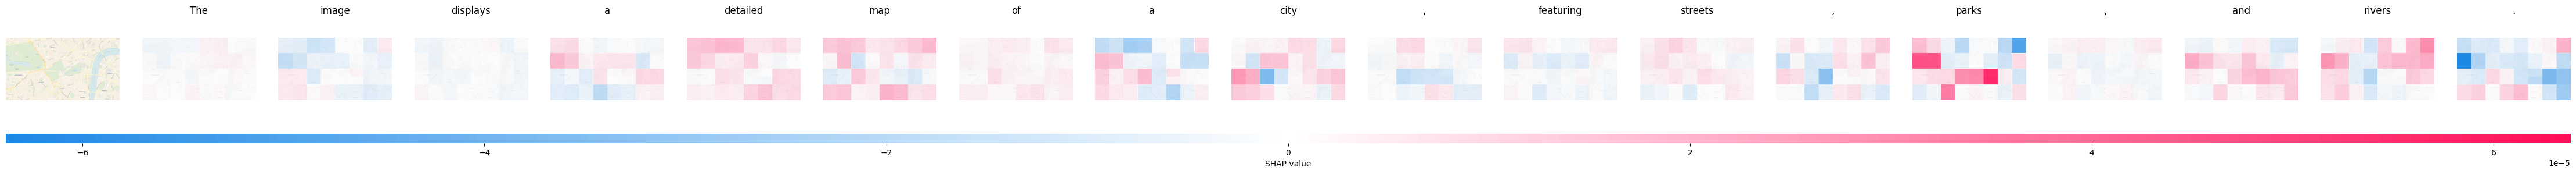

explainers.Partition is still in an alpha state, so use with caution...
Partition explainer: 2it [1:27:40, 5260.05s/it]           


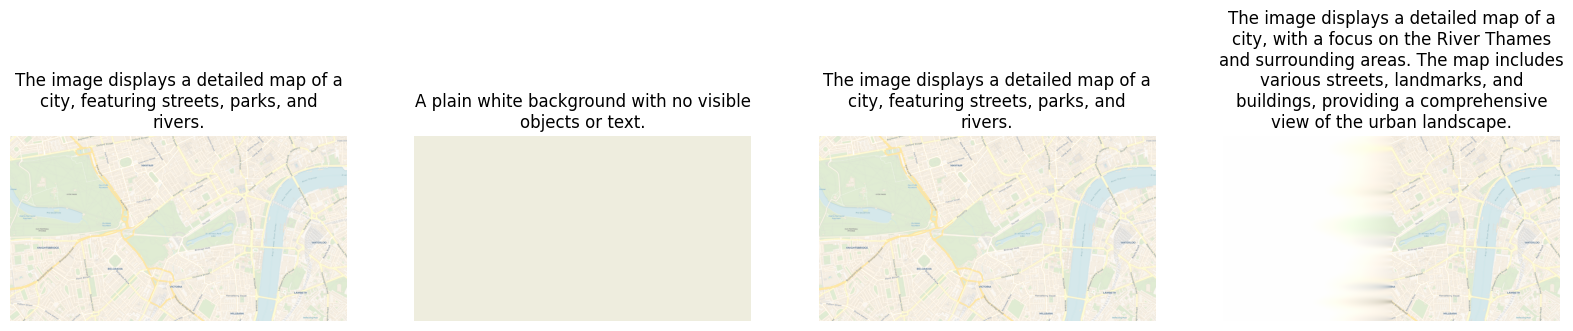

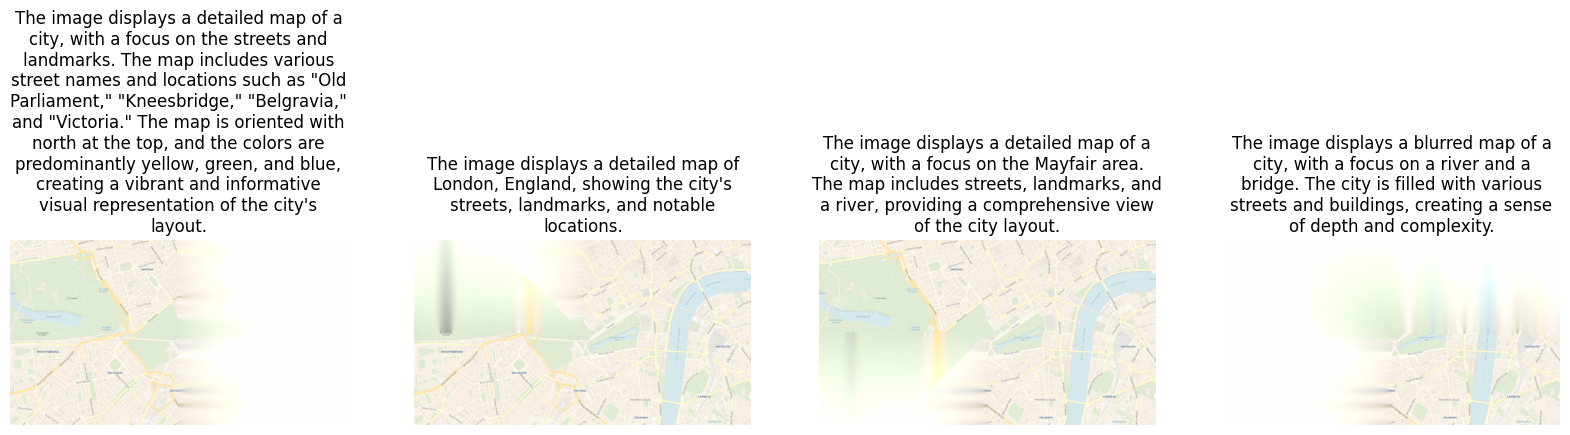

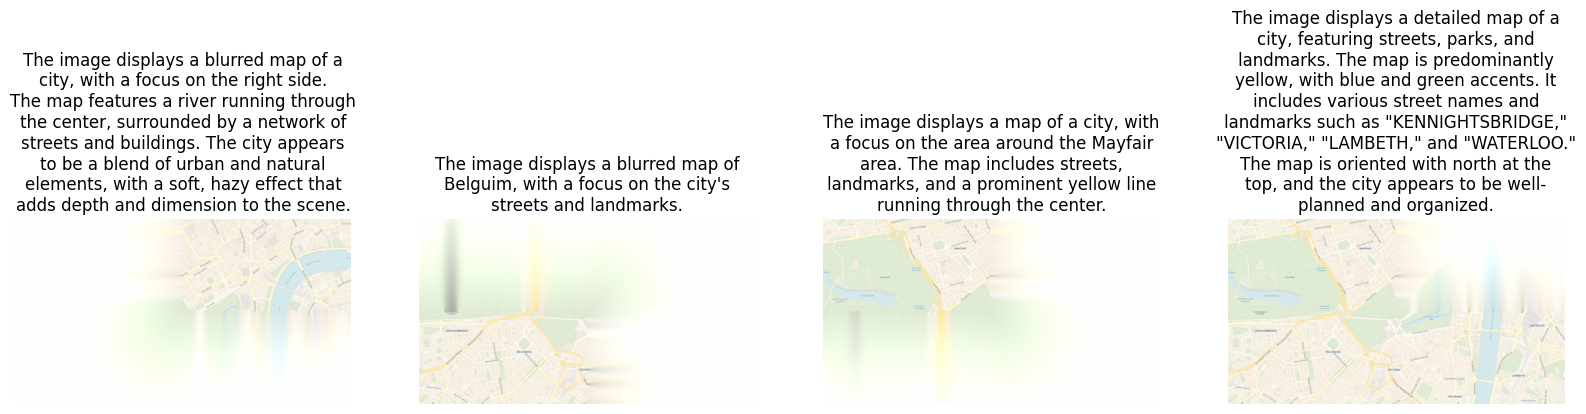

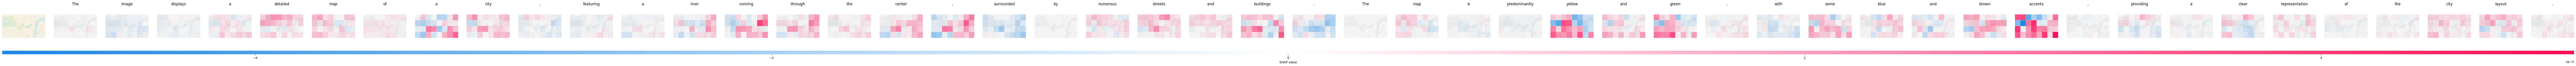

Partition explainer: 2it [1:10:07, 4207.76s/it]           


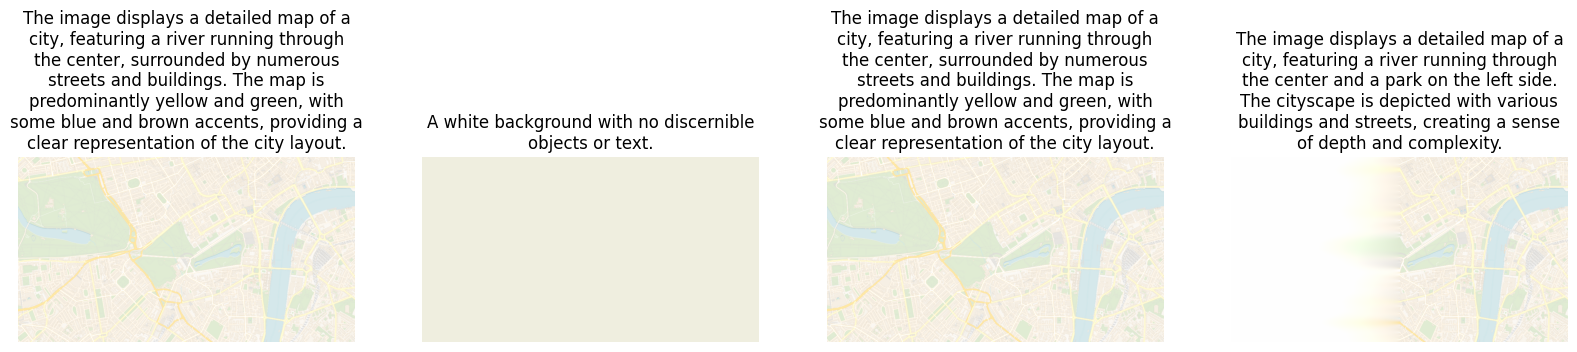

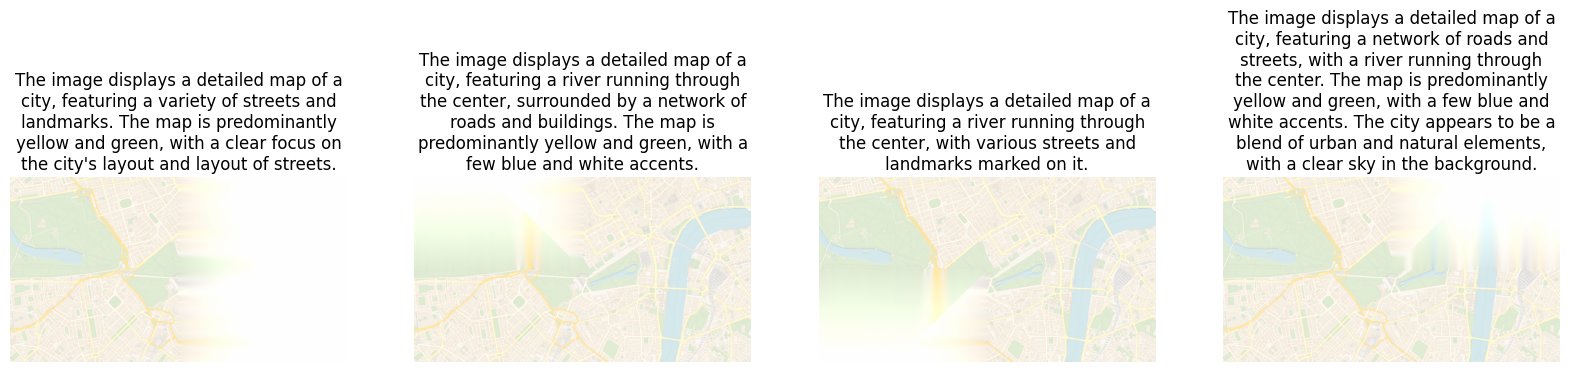

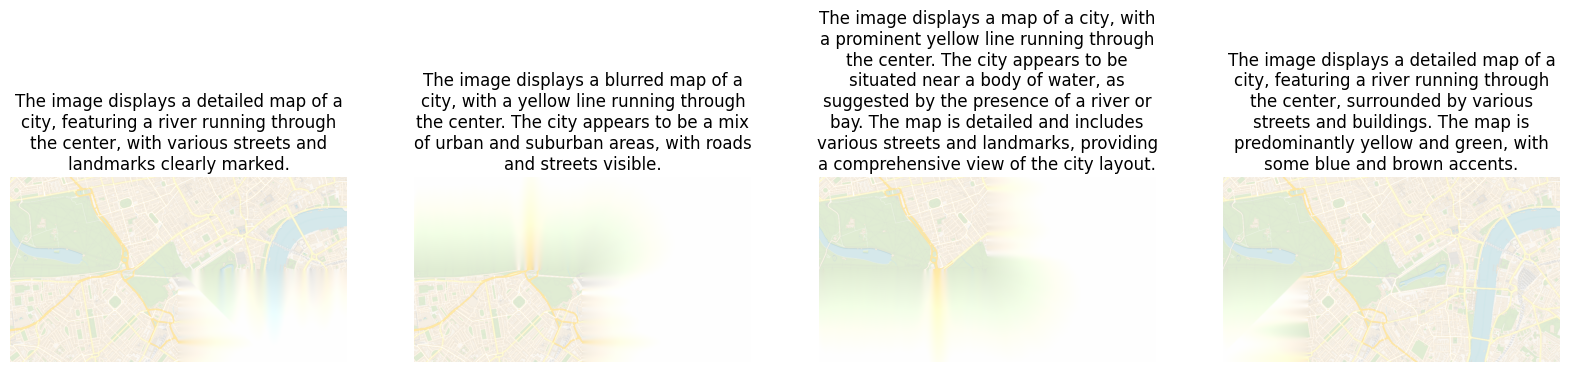

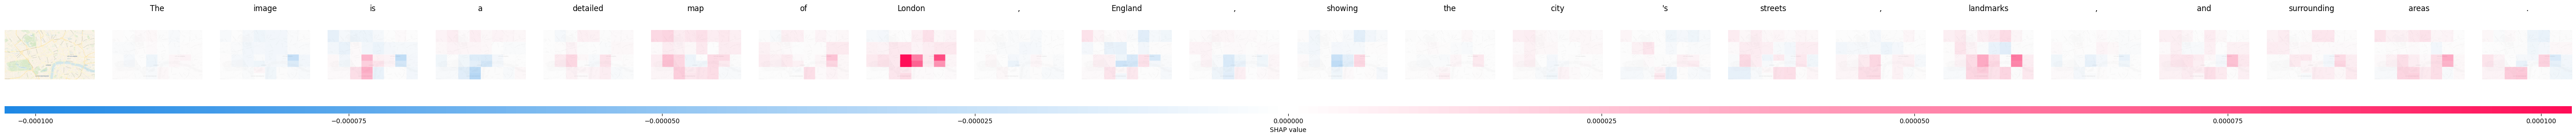

Partition explainer: 2it [1:19:39, 4779.37s/it]           


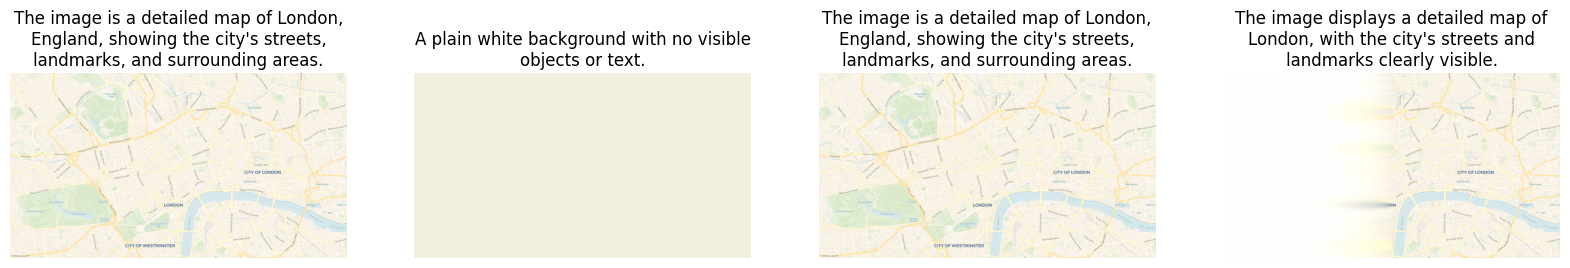

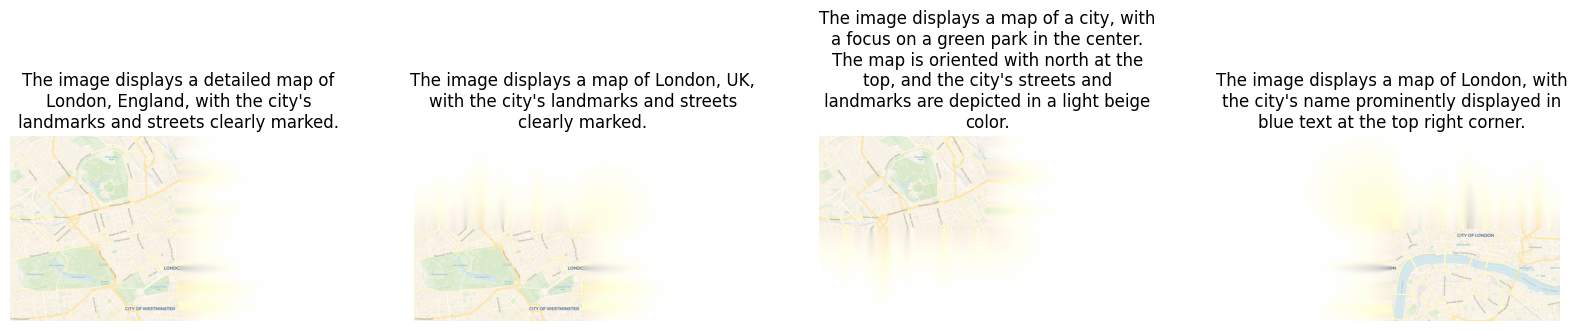

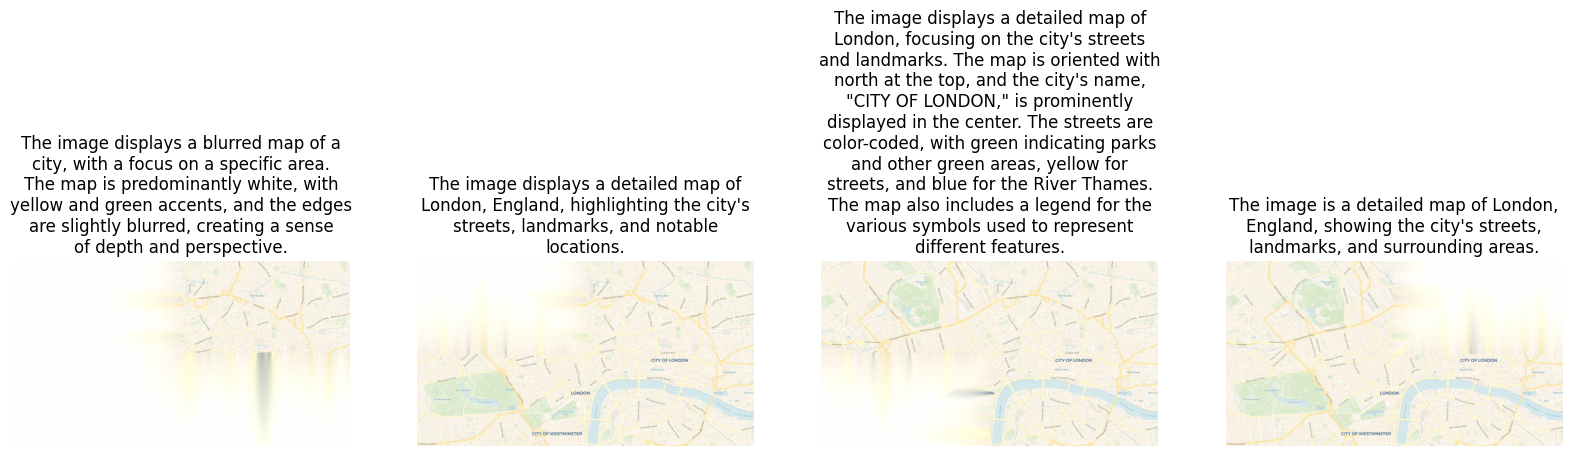

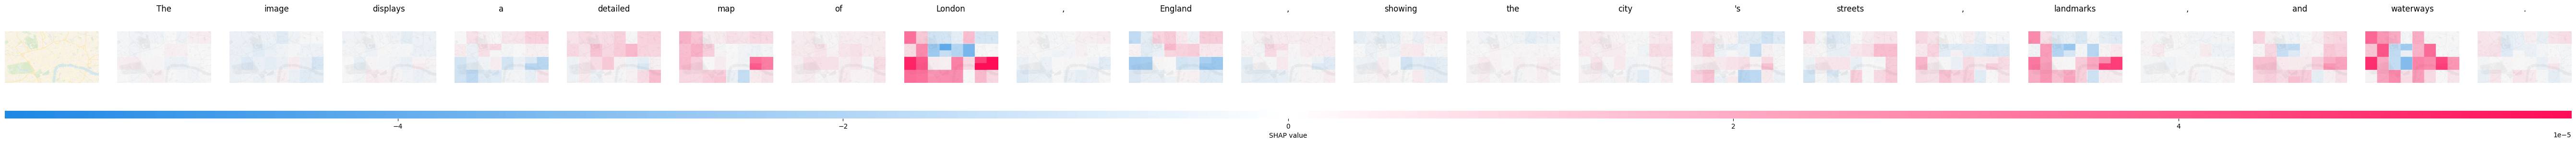

Partition explainer: 2it [1:11:39, 4299.66s/it]           


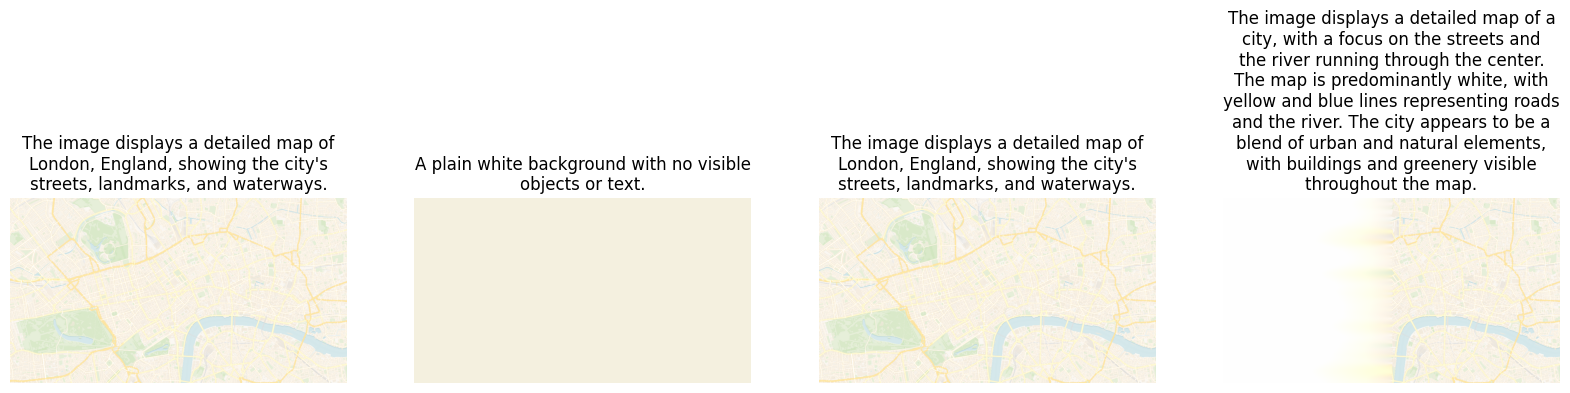

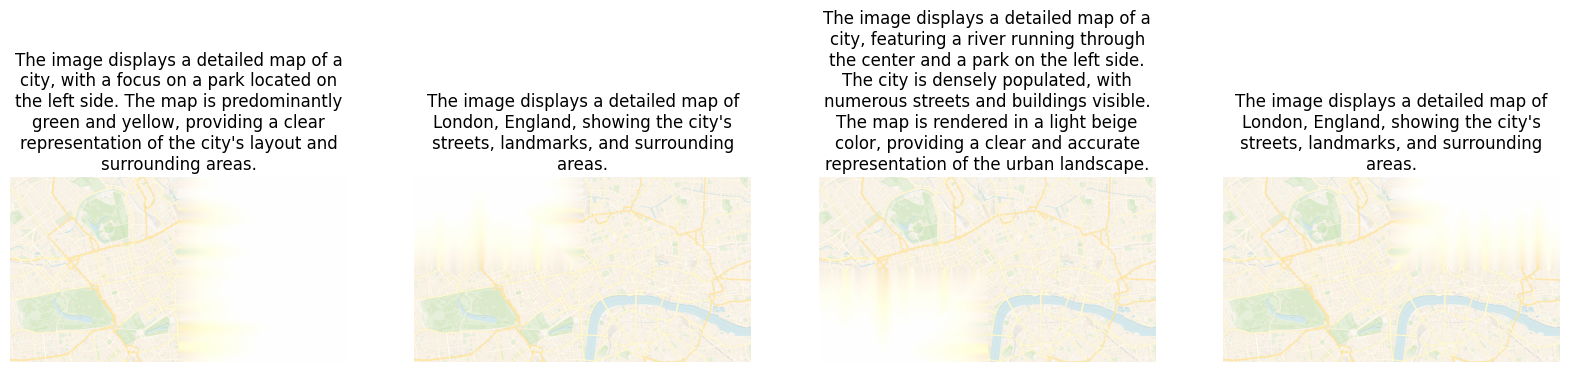

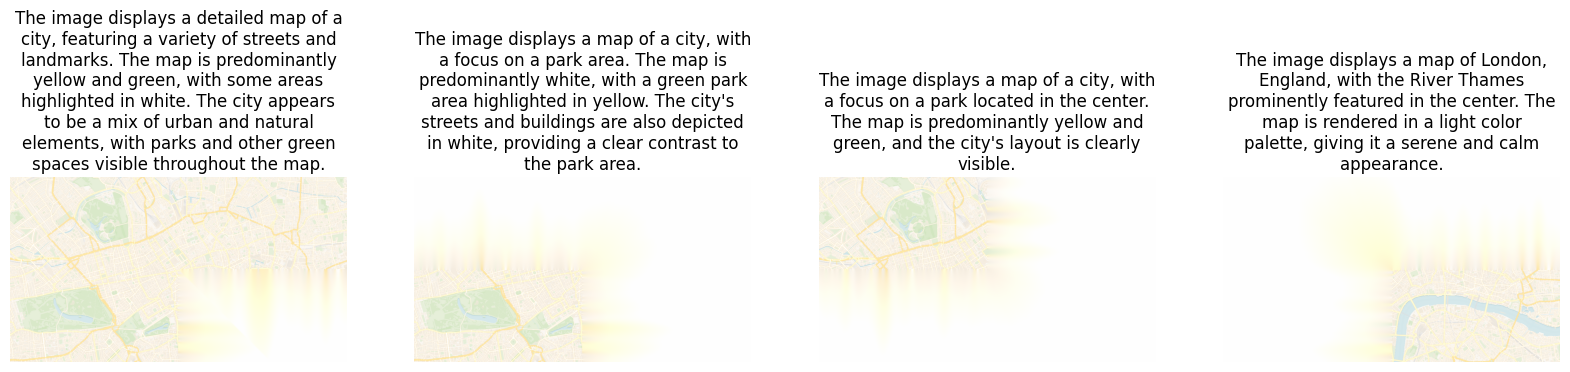

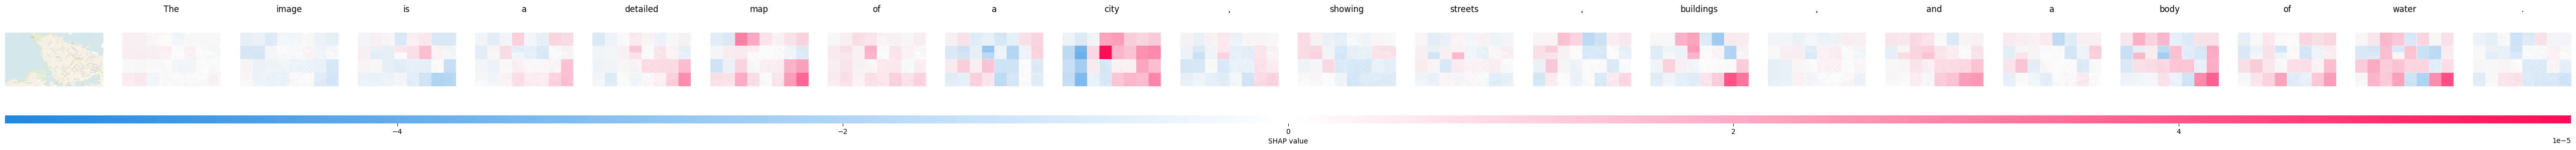

Partition explainer: 2it [1:31:46, 5506.30s/it]           


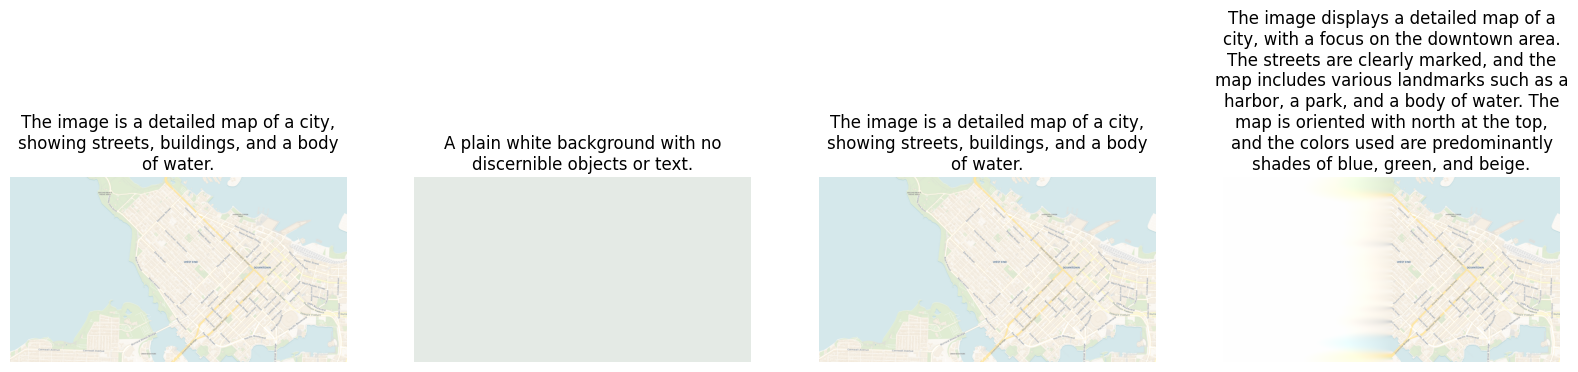

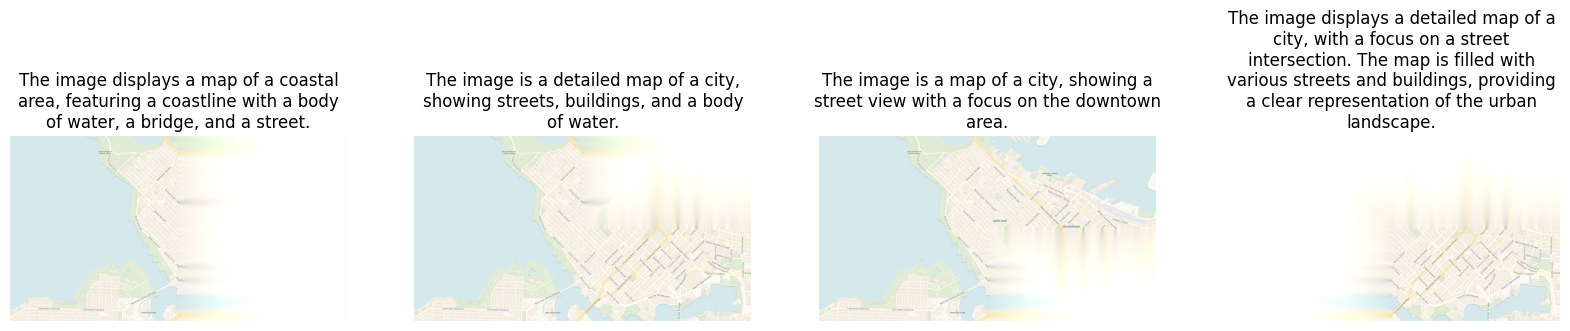

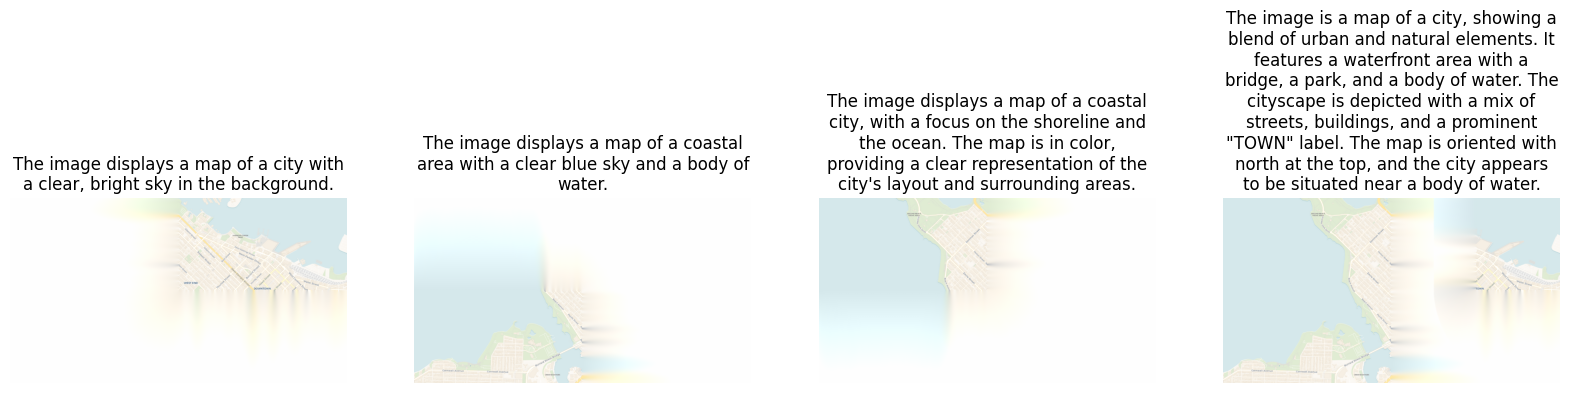

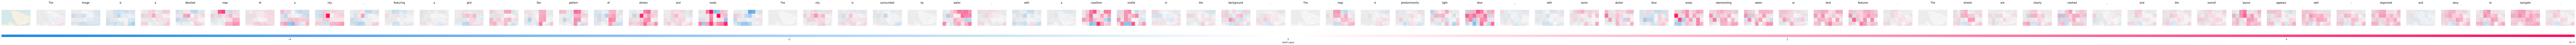

Partition explainer: 2it [1:09:50, 4190.97s/it]           


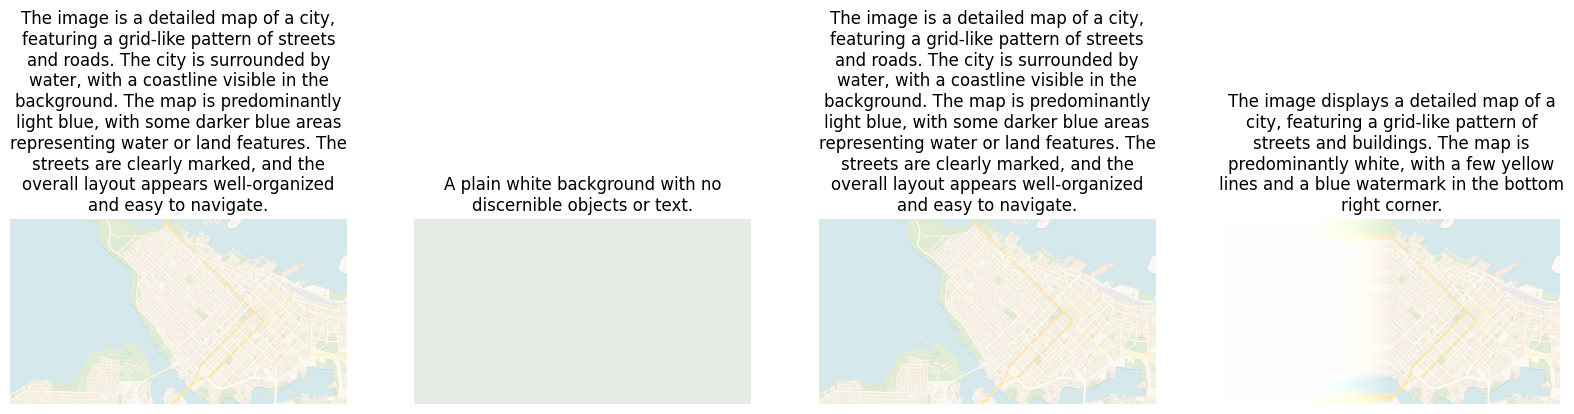

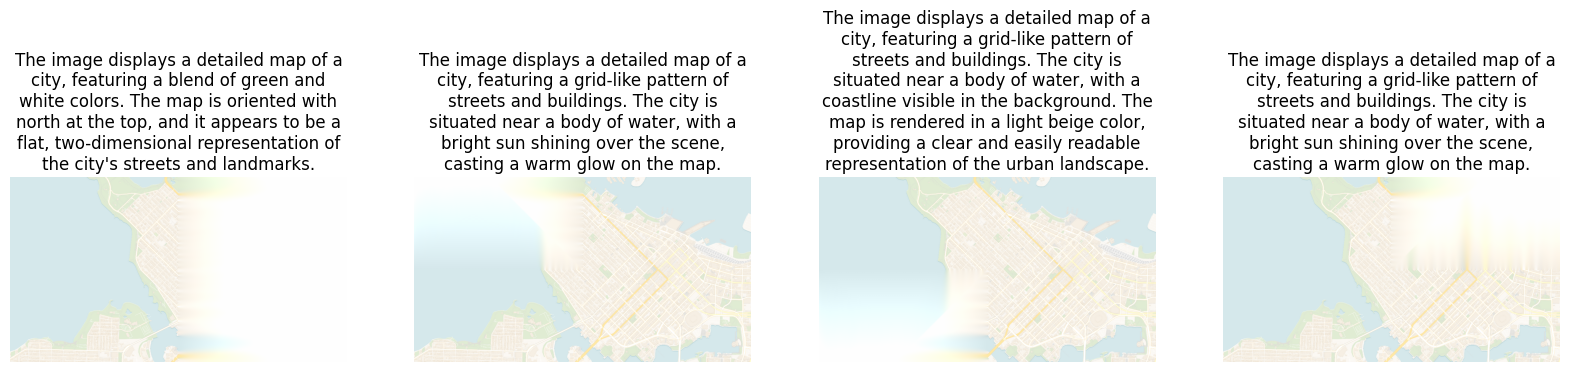

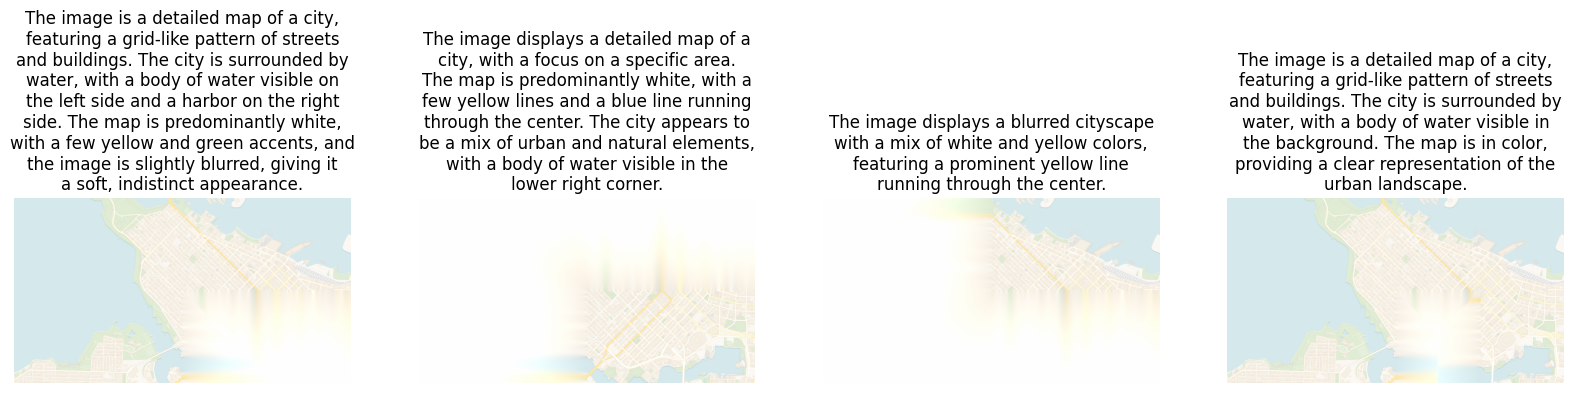

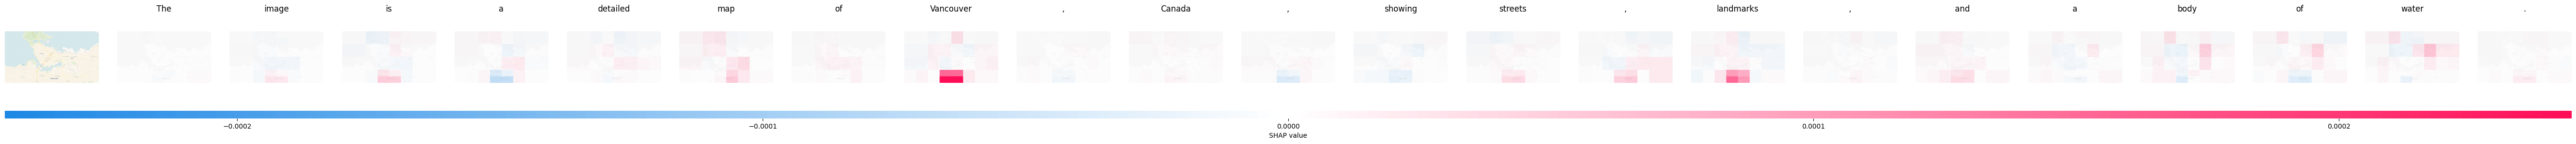

Partition explainer: 2it [1:27:10, 5230.63s/it]           


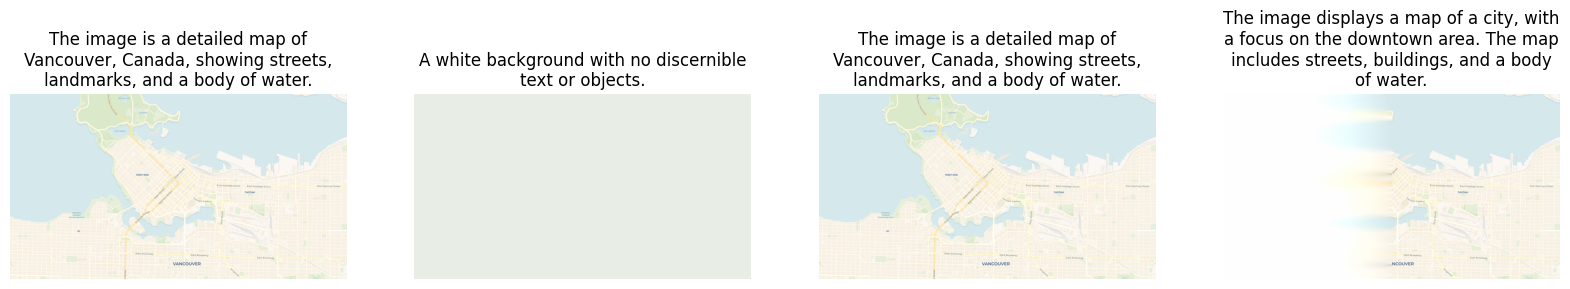

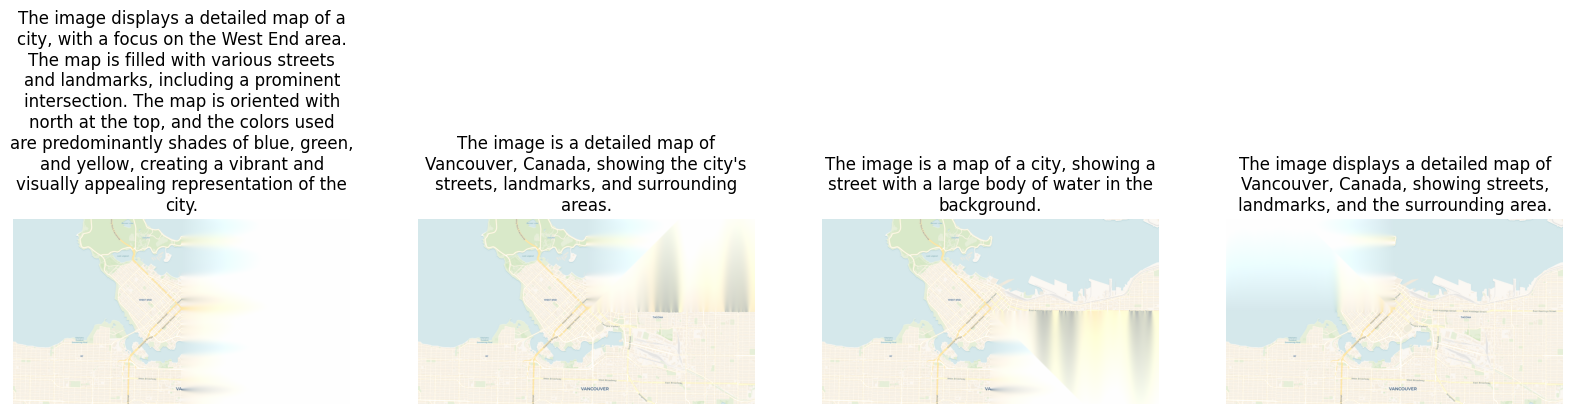

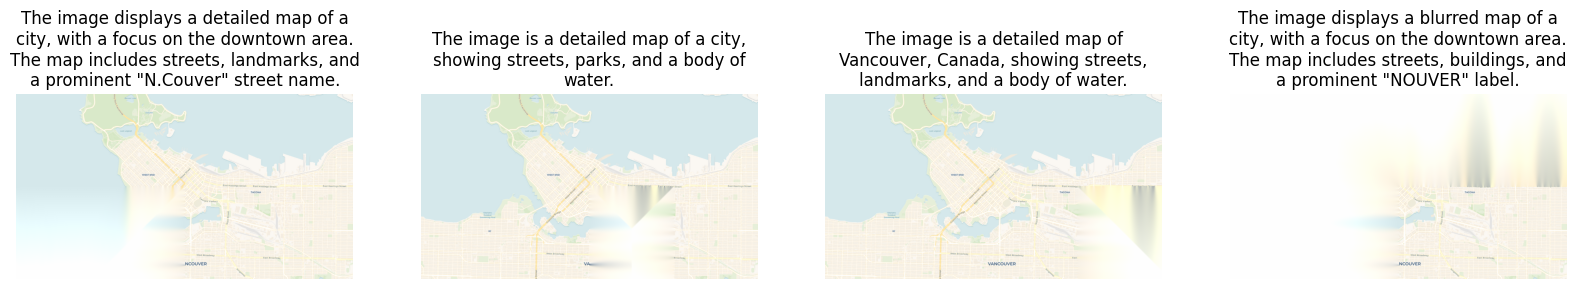

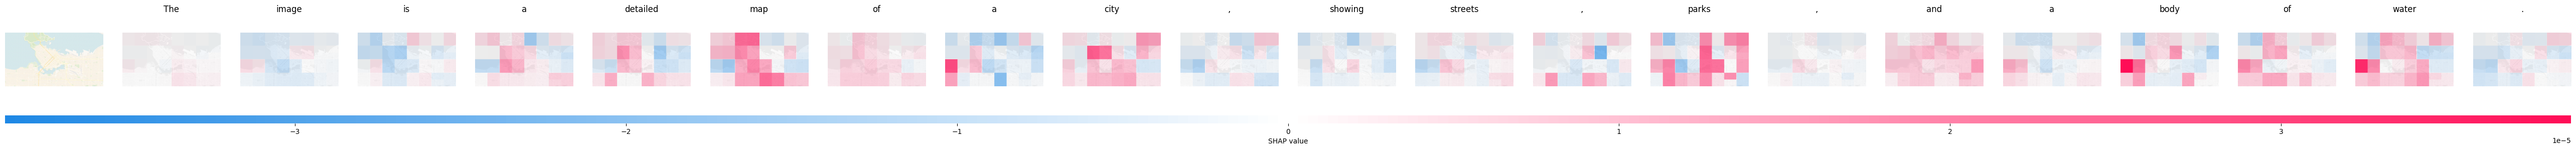

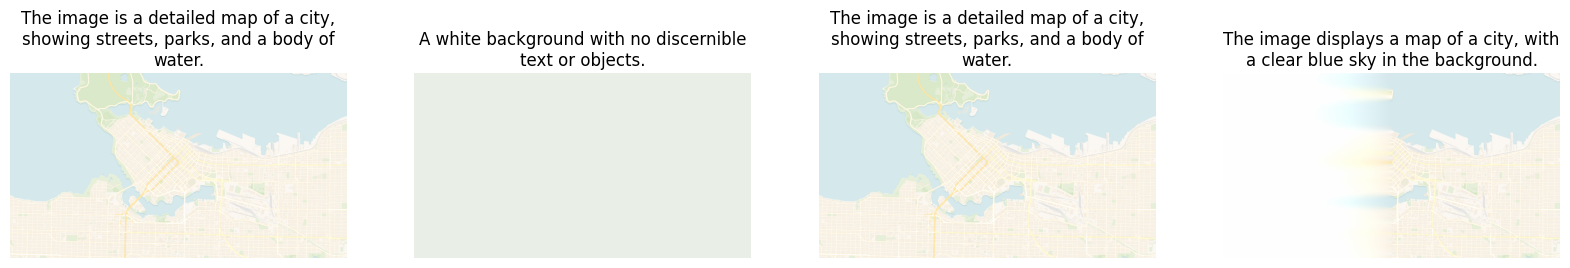

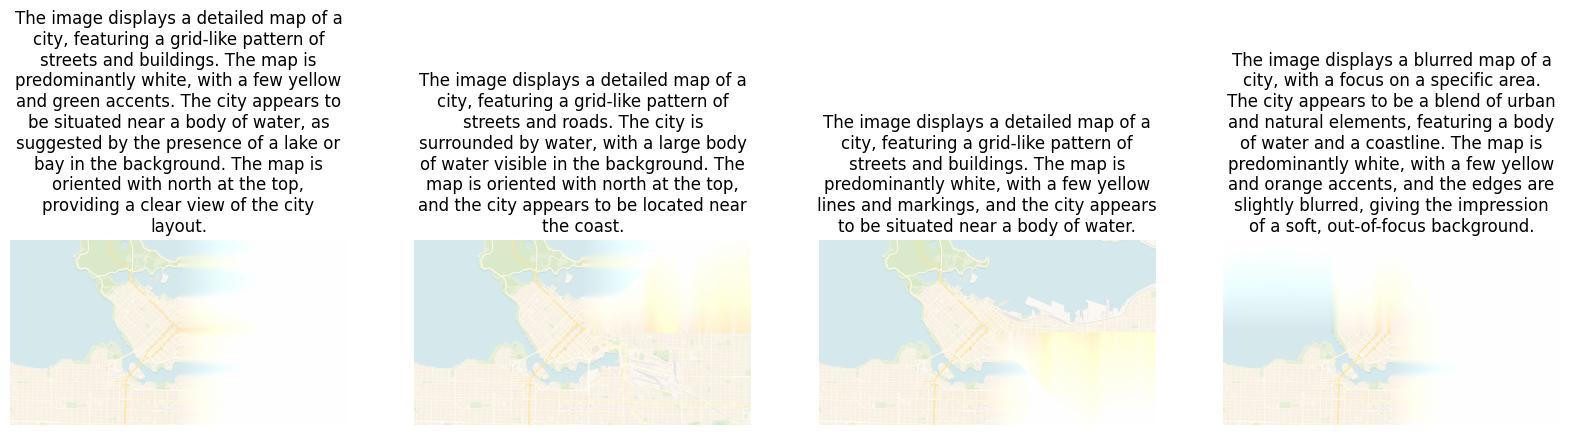

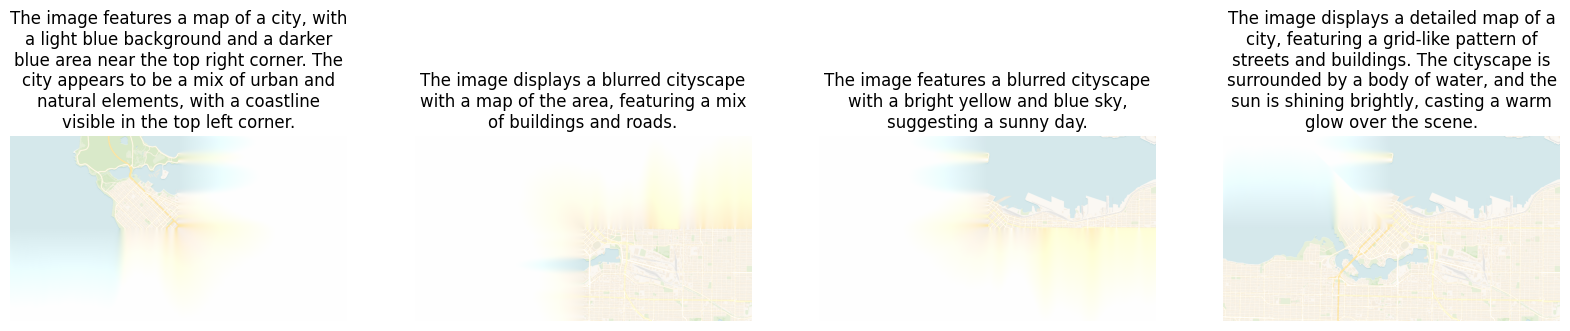

In [11]:
# run masker with test images dataset (X) and get SHAP explanations for their captions
#shap_values = run_masker(X)
shap_values = run_masker(X, mask_value="inpaint_telea", show_grid_plot=True, limit_grid=12)